In [1]:
import polars as pl

In [2]:
from sklearn.cluster import KMeans,MeanShift, estimate_bandwidth , Birch
import numpy as np
import scipy.sparse as sp
import igraph as ig
import leidenalg as la
from collections import Counter
from sklearn.metrics import adjusted_rand_score, rand_score,normalized_mutual_info_score
import networkx as nx
import community as community_louvain
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import community as community_louvain  

In [3]:
df = pl.read_csv("reddit-users.csv")
df

rotoreuters,-0.224305,0.034301,-0.082651,0.004676,0.00696,0.892179,-0.309423,0.570185,0.49211,0.667661,0.379927,-0.701833,0.494844,-0.112651,-0.499859,-0.03113,-0.17902,-0.307026,0.804202,-0.126007,0.298278,0.699318,-0.122089,-0.147698,0.347853,-0.171306,-0.324271,-0.599804,0.423248,-0.56949,-0.824675,-0.568197,-0.515359,-0.281378,-0.631208,0.31375,…,-0.337365,-0.418125,-0.084188,-0.248032,0.35677,0.028407,-0.21356,0.06294,-0.188042,0.431441,-0.472865,0.222936,0.076625,0.285511,0.222161,0.284596,-0.158964,0.182507,0.711164,0.423767,-0.486449,0.403645,-0.716357,-0.359746,0.063134,0.646768,-0.287045,-0.380348,-0.14416,-0.289317,0.471727,-0.174092,0.534364,0.218821,0.269216,-0.412621,-0.469088
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""fiplefip""",-0.306765,0.259314,-0.950335,0.560013,-0.364981,0.073359,-0.256642,-0.348088,-0.030323,-0.284338,0.377343,-0.358473,0.559322,0.062051,0.099554,0.46136,-0.273855,-0.274918,0.725871,-0.230823,-0.436114,0.186223,-0.004017,0.297142,-0.066631,0.16217,-0.364509,0.229731,-0.151828,0.22865,0.171403,-0.334804,-0.408777,-0.165566,0.274575,-0.265074,…,-0.007571,-0.811709,0.228903,-0.525756,0.513215,-0.197298,-0.706438,-0.42467,0.410469,0.16759,0.003496,0.130472,-0.59432,-0.076453,0.671613,-0.53084,0.171624,-0.14149,0.264164,-0.338885,-0.125357,-0.206496,0.660746,-0.327274,0.188642,0.439133,-0.158999,-0.432182,-0.769793,-0.434484,0.268733,-0.163076,-0.455654,0.41656,-0.219805,-0.568944,-0.477788
"""amici_ursi""",-0.234556,0.60916,-0.065395,-0.212264,0.269761,-0.562834,-0.455435,-0.349673,0.391979,0.36878,-0.332526,-0.612227,0.881066,-0.310739,0.338838,-0.069625,-0.223117,0.319171,0.984606,0.245857,0.85169,-0.294353,0.134919,-0.026722,0.360474,0.187247,-0.023172,0.356334,-0.13018,-0.085904,-0.098366,0.615505,0.404617,0.230763,-0.305228,0.863486,…,-0.144152,-0.504473,-0.384659,-0.827701,0.187106,-0.053623,-0.003742,-0.774822,0.251569,-0.868102,-0.863559,-0.002648,0.084968,0.187232,-0.172234,0.728021,-0.188714,0.579466,-0.209696,0.877766,-0.14669,-0.592308,-0.037788,-0.548592,0.301136,0.873749,0.233379,0.622636,0.23427,0.083597,-0.647548,0.103007,0.344196,0.140004,0.579194,-0.046483,-0.705478
"""unremovable""",0.253033,0.548086,-0.538728,0.375164,-0.129068,0.307664,-0.047697,-0.492977,0.224615,0.073754,-0.286705,0.011221,0.601635,-0.535227,-0.487574,-0.058265,-0.224699,0.003262,0.889734,-0.533337,-0.315974,0.377092,0.833714,-0.320869,0.634363,0.197973,0.561948,0.049643,0.112593,0.308731,-0.208679,0.16751,0.39875,0.018139,0.002018,0.76555,…,-0.180951,0.170767,-0.143426,-0.521084,-0.232333,0.294799,-0.117459,0.053756,0.421318,0.052284,-0.262025,0.164859,-0.848743,0.55363,0.349082,-0.135026,0.635478,-0.2771,0.335012,0.315789,0.046486,0.604992,-0.487021,-0.582454,-0.287221,0.907134,-0.38617,0.165165,-0.21692,-0.414641,-0.144242,0.18506,0.356242,0.095848,0.40301,-0.320782,-0.735368
"""CDRE_64""",-0.008056,0.05056,-0.295054,-0.046483,0.04242,0.345231,0.075705,-0.198281,0.139585,0.174352,0.134547,-0.214878,0.495939,-0.149515,-0.077004,0.404769,-0.250609,-0.405186,0.347727,-0.11806,0.313708,-0.187699,0.101371,-0.073235,0.188572,0.095709,-0.108428,0.193696,-0.135239,-0.310914,-0.224337,0.133148,-0.112955,-0.063444,-0.525183,0.218605,…,-0.270214,-0.122056,-0.028533,-0.358274,0.002222,-0.025049,-0.344229,-0.11333,0.094965,-0.26357,-0.364839,-0.003944,-0.093974,-0.101392,0.161158,0.124243,-0.125217,-0.032501,0.328473,0.337958,-0.156932,0.002218,-0.24986,-0.15847,0.123921,0.427048,-0.048551,-0.221219,-0.474621,-0.149465,-0.156034,-0.115828,-0.170805,0.284541,-0.14477,-0.05001,-0.341634
"""noeatnosleep""",0.313406,0.702873,0.076761,-0.511176,0.374304,-0.247656,0.148855,-0.616189,-0.144205,0.222953,-0.183565,-0.363646,0.869296,-0.146551,0.176667,-0.178732,0.01879

In [4]:
usernames = df["rotoreuters"].to_list()
X = df.drop("rotoreuters")
X

-0.224305,0.034301,-0.082651,0.004676,0.00696,0.892179,-0.309423,0.570185,0.49211,0.667661,0.379927,-0.701833,0.494844,-0.112651,-0.499859,-0.03113,-0.17902,-0.307026,0.804202,-0.126007,0.298278,0.699318,-0.122089,-0.147698,0.347853,-0.171306,-0.324271,-0.599804,0.423248,-0.56949,-0.824675,-0.568197,-0.515359,-0.281378,-0.631208,0.31375,0.43415,…,-0.337365,-0.418125,-0.084188,-0.248032,0.35677,0.028407,-0.21356,0.06294,-0.188042,0.431441,-0.472865,0.222936,0.076625,0.285511,0.222161,0.284596,-0.158964,0.182507,0.711164,0.423767,-0.486449,0.403645,-0.716357,-0.359746,0.063134,0.646768,-0.287045,-0.380348,-0.14416,-0.289317,0.471727,-0.174092,0.534364,0.218821,0.269216,-0.412621,-0.469088
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.306765,0.259314,-0.950335,0.560013,-0.364981,0.073359,-0.256642,-0.348088,-0.030323,-0.284338,0.377343,-0.358473,0.559322,0.062051,0.099554,0.46136,-0.273855,-0.274918,0.725871,-0.230823,-0.436114,0.186223,-0.004017,0.297142,-0.066631,0.16217,-0.364509,0.229731,-0.151828,0.22865,0.171403,-0.334804,-0.408777,-0.165566,0.274575,-0.265074,0.429774,…,-0.007571,-0.811709,0.228903,-0.525756,0.513215,-0.197298,-0.706438,-0.42467,0.410469,0.16759,0.003496,0.130472,-0.59432,-0.076453,0.671613,-0.53084,0.171624,-0.14149,0.264164,-0.338885,-0.125357,-0.206496,0.660746,-0.327274,0.188642,0.439133,-0.158999,-0.432182,-0.769793,-0.434484,0.268733,-0.163076,-0.455654,0.41656,-0.219805,-0.568944,-0.477788
-0.234556,0.60916,-0.065395,-0.212264,0.269761,-0.562834,-0.455435,-0.349673,0.391979,0.36878,-0.332526,-0.612227,0.881066,-0.310739,0.338838,-0.069625,-0.223117,0.319171,0.984606,0.245857,0.85169,-0.294353,0.134919,-0.026722,0.360474,0.187247,-0.023172,0.356334,-0.13018,-0.085904,-0.098366,0.615505,0.404617,0.230763,-0.305228,0.863486,0.072753,…,-0.144152,-0.504473,-0.384659,-0.827701,0.187106,-0.053623,-0.003742,-0.774822,0.251569,-0.868102,-0.863559,-0.002648,0.084968,0.187232,-0.172234,0.728021,-0.188714,0.579466,-0.209696,0.877766,-0.14669,-0.592308,-0.037788,-0.548592,0.301136,0.873749,0.233379,0.622636,0.23427,0.083597,-0.647548,0.103007,0.344196,0.140004,0.579194,-0.046483,-0.705478
0.253033,0.548086,-0.538728,0.375164,-0.129068,0.307664,-0.047697,-0.492977,0.224615,0.073754,-0.286705,0.011221,0.601635,-0.535227,-0.487574,-0.058265,-0.224699,0.003262,0.889734,-0.533337,-0.315974,0.377092,0.833714,-0.320869,0.634363,0.197973,0.561948,0.049643,0.112593,0.308731,-0.208679,0.16751,0.39875,0.018139,0.002018,0.76555,0.261157,…,-0.180951,0.170767,-0.143426,-0.521084,-0.232333,0.294799,-0.117459,0.053756,0.421318,0.052284,-0.262025,0.164859,-0.848743,0.55363,0.349082,-0.135026,0.635478,-0.2771,0.335012,0.315789,0.046486,0.604992,-0.487021,-0.582454,-0.287221,0.907134,-0.38617,0.165165,-0.21692,-0.414641,-0.144242,0.18506,0.356242,0.095848,0.40301,-0.320782,-0.735368
-0.008056,0.05056,-0.295054,-0.046483,0.04242,0.345231,0.075705,-0.198281,0.139585,0.174352,0.134547,-0.214878,0.495939,-0.149515,-0.077004,0.404769,-0.250609,-0.405186,0.347727,-0.11806,0.313708,-0.187699,0.101371,-0.073235,0.188572,0.095709,-0.108428,0.193696,-0.135239,-0.310914,-0.224337,0.133148,-0.112955,-0.063444,-0.525183,0.218605,0.149472,…,-0.270214,-0.122056,-0.028533,-0.358274,0.002222,-0.025049,-0.344229,-0.11333,0.094965,-0.26357,-0.364839,-0.003944,-0.093974,-0.101392,0.161158,0.124243,-0.125217,-0.032501,0.328473,0.337958,-0.156932,0.002218,-0.24986,-0.15847,0.123921,0.427048,-0.048551,-0.221219,-0.474621,-0.149465,-0.156034,-0.115828,-0.170805,0.284541,-0.14477,-0.05001,-0.341634
0.313406,0.702873,0.076761,-0.511176,0.374304,-0.247656,0.148855,-0.616189,-0.144205,0.222953,-0.183565,-0.363646,0.869296,-0.146551,0.176667,-0.178732,0.018797,-0.18148,1.014249,-0.096242,0.79333,0.656905,-0.1

In [5]:
from scipy.sparse import csr_matrix

In [6]:
k = 20

nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(X)
distances, indices = nbrs.kneighbors(X)

In [7]:
rows = np.repeat(np.arange(len(X)), k)
cols = indices.flatten()
vals = 1 - distances.flatten()        # تبدیل distance → similarity

A = sp.csr_matrix((vals, (rows, cols)), shape=(len(X), len(X)))
A

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2367600 stored elements and shape (118380, 118380)>

In [8]:
print("نوع داده:", type(A))
print("شکل ماتریس:", A.shape)
print("تعداد عناصر غیر صفر:", A.nnz)
print("تراکم (density):", A.nnz / (A.shape[0] * A.shape[1]))

نوع داده: <class 'scipy.sparse._csr.csr_matrix'>
شکل ماتریس: (118380, 118380)
تعداد عناصر غیر صفر: 2367600
تراکم (density): 0.00016894745734076703


### ماتریس رو متقارن میکنیم 

In [9]:
symmetric_matrix = A.maximum(A.T)
symmetric_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4416036 stored elements and shape (118380, 118380)>

In [10]:
print("نوع داده:", type(symmetric_matrix))
print("شکل ماتریس:", symmetric_matrix.shape)
print("تعداد عناصر غیر صفر:", symmetric_matrix.nnz)
print("تراکم (density):", symmetric_matrix.nnz / (symmetric_matrix.shape[0] * symmetric_matrix.shape[1]))

نوع داده: <class 'scipy.sparse._csr.csr_matrix'>
شکل ماتریس: (118380, 118380)
تعداد عناصر غیر صفر: 4416036
تراکم (density): 0.0003151199753865904


In [11]:
import community.community_louvain as community_louvain

In [12]:
G = nx.Graph()
rows, cols = symmetric_matrix.nonzero()
for i, j in zip(rows, cols):
    if i < j:  # فقط یک سمت برای گراف غیرجهتی
        G.add_edge(i, j, weight=symmetric_matrix[i, j])
partition = community_louvain.best_partition(G, weight='weight')
(partition)

{np.int32(0): 0,
 np.int32(3): 0,
 np.int32(256): 1,
 np.int32(313): 0,
 np.int32(534): 0,
 np.int32(954): 2,
 np.int32(1312): 2,
 np.int32(1377): 3,
 np.int32(1618): 4,
 np.int32(2102): 5,
 np.int32(3983): 4,
 np.int32(4985): 1,
 np.int32(6057): 4,
 np.int32(6277): 6,
 np.int32(11625): 6,
 np.int32(21910): 30,
 np.int32(24455): 2,
 np.int32(31300): 6,
 np.int32(41825): 2,
 np.int32(64963): 2,
 np.int32(1): 0,
 np.int32(77): 0,
 np.int32(144): 0,
 np.int32(215): 0,
 np.int32(290): 8,
 np.int32(696): 0,
 np.int32(2382): 5,
 np.int32(2803): 0,
 np.int32(3217): 8,
 np.int32(6367): 9,
 np.int32(6655): 0,
 np.int32(8526): 0,
 np.int32(15605): 0,
 np.int32(22510): 0,
 np.int32(36582): 9,
 np.int32(52677): 11,
 np.int32(66248): 12,
 np.int32(98396): 0,
 np.int32(109679): 0,
 np.int32(2): 13,
 np.int32(192): 13,
 np.int32(325): 5,
 np.int32(340): 2,
 np.int32(407): 14,
 np.int32(429): 13,
 np.int32(523): 13,
 np.int32(548): 30,
 np.int32(668): 13,
 np.int32(1269): 15,
 np.int32(3950): 4,
 np.i

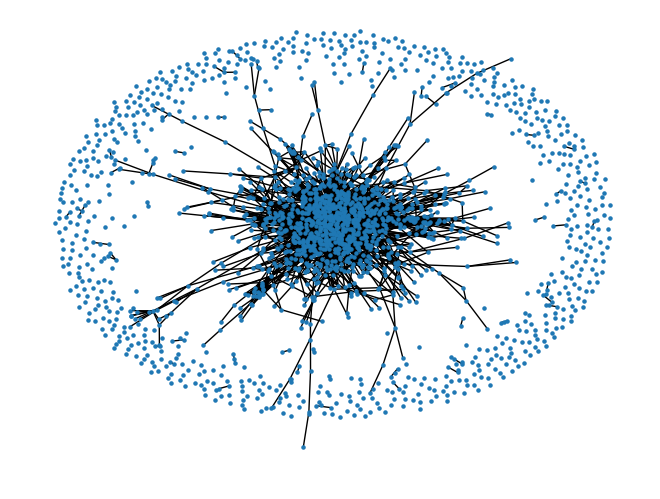

In [13]:
#رسم گراف
sample = list(range(2000))
H = G.subgraph(sample)

nx.draw(H, node_size=5)

In [14]:
from networkx.algorithms.community.quality import modularity

In [15]:
class EvaluationMetrics:
    def __init__(self, graph=None, partition=None):
        """
        graph: NetworkX Graph
        partition: dictionary {node: community_id}
        """
        self.graph = graph
        self.partition = partition

        # metrics
        self.y_true = None
        self.y_pred = None

        self._purity = None
        self._nmi = None
        self._ari = None
        self._ri = None
        self._modularity = None

    # Purity
    def _compute_purity(self):
        y_true = np.asarray(self.y_true)
        y_pred = np.asarray(self.y_pred)

        clusters = np.unique(y_pred)
        N = len(y_true)
        total = 0

        for c in clusters:
            idx = np.where(y_pred == c)[0]
            true_labels = y_true[idx]
            if len(true_labels) == 0:
                continue
            most_common = Counter(true_labels).most_common(1)[0][1]
            total += most_common

        return total / N

    # MAIN FIT
    def fit(self, y_true, y_pred):
        """
        y_true, y_pred should be 1D arrays
        """
        self.y_true = np.asarray(list(y_true))
        self.y_pred = np.asarray(list(y_pred))

        # purity
        self._purity = self._compute_purity()

        # nmi
        self._nmi = normalized_mutual_info_score(self.y_true, self.y_pred)

        # ari
        self._ari = adjusted_rand_score(self.y_true, self.y_pred)

        # ri
        self._ri = rand_score(self.y_true, self.y_pred)

        # modularity (NetworkX)
        if self.graph is not None and self.partition is not None:
            # partition must be list of sets
            communities = {}
            for node, com in self.partition.items():
                communities.setdefault(com, set()).add(node)
            community_list = list(communities.values())

            try:
                self._modularity = modularity(self.graph, community_list, weight="weight")
            except:
                self._modularity = None

        return self

    # GETTERS
    def score_purity(self):
        return self._purity

    def score_nmi(self):
        return self._nmi

    def score_ari(self):
        return self._ari

    def score_ri(self):
        return self._ri

    def score_modularity(self):
        return self._modularity

In [16]:
x = partition.values()
x

dict_values([0, 0, 1, 0, 0, 2, 2, 3, 4, 5, 4, 1, 4, 6, 6, 30, 2, 6, 2, 2, 0, 0, 0, 0, 8, 0, 5, 0, 8, 9, 0, 0, 0, 0, 9, 11, 12, 0, 0, 13, 13, 5, 2, 14, 13, 13, 30, 13, 15, 4, 12, 30, 13, 16, 0, 2, 0, 0, 0, 0, 9, 0, 12, 14, 13, 13, 0, 13, 17, 2, 18, 20, 0, 15, 2, 13, 13, 0, 5, 13, 20, 0, 0, 0, 0, 22, 0, 0, 0, 2, 16, 0, 2, 18, 15, 0, 0, 0, 17, 20, 0, 6, 8, 1, 8, 13, 0, 0, 0, 0, 13, 17, 0, 0, 0, 18, 0, 0, 22, 8, 13, 23, 13, 17, 0, 0, 16, 2, 2, 0, 0, 13, 0, 2, 0, 24, 15, 5, 13, 5, 14, 0, 2, 2, 2, 0, 2, 16, 8, 2, 0, 18, 0, 0, 5, 14, 1, 11, 14, 24, 0, 14, 16, 13, 30, 25, 8, 4, 13, 0, 30, 0, 0, 8, 5, 26, 24, 27, 22, 14, 0, 13, 8, 14, 17, 13, 0, 5, 0, 0, 0, 0, 6, 0, 30, 20, 0, 11, 17, 0, 0, 20, 17, 2, 11, 13, 0, 0, 2, 20, 18, 0, 25, 8, 0, 27, 18, 24, 0, 13, 15, 15, 13, 1, 0, 0, 0, 0, 0, 0, 23, 0, 0, 5, 2, 0, 13, 0, 8, 0, 16, 0, 16, 0, 24, 0, 0, 20, 29, 2, 0, 2, 15, 0, 0, 0, 13, 16, 0, 13, 0, 8, 5, 30, 14, 0, 6, 0, 6, 13, 13, 5, 15, 13, 22, 0, 8, 0, 0, 5, 0, 2, 4, 2, 13, 0, 0, 13, 31, 0, 0, 14, 

In [17]:
metrics = EvaluationMetrics(graph=G, partition=partition)
x = list(partition.values())
metrics.fit(x,x)

print("Purity:", metrics.score_purity())
print("NMI:", metrics.score_nmi())
print("ARI:", metrics.score_ari())
print("RI:", metrics.score_ri())
print("Modularity:", round(metrics.score_modularity(),3))

Purity: 1.0
NMI: 1.0
ARI: 1.0
RI: 1.0
Modularity: 0.655


### معیار های درست 

In [18]:
class CommunityMetrics:
    def __init__(self, graph, partition):
        """
        graph: networkx.Graph
        partition: dict {node: community_id} یا list[list(nodes)]
        """
        self.graph = graph
        
        # اگر partition دیکشنری است، آن را به لیست لیست تبدیل می‌کنیم
        if isinstance(partition, dict):
            communities = {}
            for node, c in partition.items():
                communities.setdefault(c, []).append(node)
            self.communities = list(communities.values())
        else:
            self.communities = partition

    # 1. Modularity (Newman)
    def modularity(self):
        return nx.algorithms.community.quality.modularity(self.graph, self.communities, weight='weight')

    # 2. Conductance
    def conductance(self):
        conductances = []
        for community in self.communities:
            cut_size = nx.algorithms.cut_size(self.graph, community, weight='weight')
            volume = sum([self.graph.degree(n, weight='weight') for n in community])
            if volume == 0:
                continue
            conductances.append(cut_size / volume)
        return np.mean(conductances)

    # 3. Cut Ratio
    def cut_ratio(self):
        n = self.graph.number_of_nodes()
        m = self.graph.number_of_edges()
        total_cut = 0
        for community in self.communities:
            cut_edges = nx.algorithms.cut_size(self.graph, community, weight='weight')
            total_cut += cut_edges
        if n*(n-1)/2 == 0:
            return 0
        return total_cut / (n*(n-1)/2)

    # 4. Expansion
    def expansion(self):
        expansions = []
        for community in self.communities:
            cut_edges = nx.algorithms.cut_size(self.graph, community, weight='weight')
            expansions.append(cut_edges / len(community))
        return np.mean(expansions)

    # 5. Flake-ODF
    def flake_odf(self):
        flakes = []
        for community in self.communities:
            for node in community:
                out_edges = sum(1 for neighbor in self.graph.neighbors(node) if neighbor not in community)
                if self.graph.degree(node) > 0:
                    if out_edges > self.graph.degree(node)/2:
                        flakes.append(1)
                    else:
                        flakes.append(0)
        if len(flakes) == 0:
            return 0
        return np.mean(flakes)

    # 6. Average Out-Degree Fraction (AODF)
    def aodf(self):
        fractions = []
        for community in self.communities:
            for node in community:
                out_edges = sum(1 for neighbor in self.graph.neighbors(node) if neighbor not in community)
                deg = self.graph.degree(node)
                if deg > 0:
                    fractions.append(out_edges / deg)
        if len(fractions) == 0:
            return 0
        return np.mean(fractions)

    # 7. Modularity Density (Densely connected communities)
    def modularity_density(self):
        total = 0
        m = self.graph.number_of_edges()
        for community in self.communities:
            subgraph = self.graph.subgraph(community)
            lc = subgraph.number_of_edges()
            dc = len(community)*(len(community)-1)/2
            if dc > 0:
                total += lc/dc
        return total / len(self.communities)

In [19]:
metrics = CommunityMetrics(G, partition)

print("Modularity:", round(metrics.modularity(),3))
print("Conductance:", round(metrics.conductance(),3))
print("Cut Ratio:", round(metrics.cut_ratio(),4))
print("Expansion:", round(metrics.expansion(),3))
print("Flake ODF:", (metrics.flake_odf()))
print("AODF:", round(metrics.aodf(),3))
print("Modularity Density:", round(metrics.modularity_density(),3))

Modularity: 0.655
Conductance: 0.25
Cut Ratio: 0.0001
Expansion: 4.82
Flake ODF: 0.3270400405473898
AODF: 0.373
Modularity Density: 0.053


Modularity = 0.655 معیاریه که نشون می‌ده تقسیم‌بندی گراف چقدر خوب اجتماع‌ها رو جدا کرده. عدد نزدیک به 1 یعنی اجتماع‌ها خیلی واضح و جدا هستن. 0.655 یعنی کیفیت نسبتاً خوب.

Conductance = 0.25 نسبت یال‌های بین اجتماع‌ها به یال‌های داخل اجتماع. هرچه کمتر باشه، اجتماع‌ها جدا‌تر هستن. 0.25 یعنی ارتباط بین اجتماع‌ها کم ولی نه خیلی ناچیزه.

Cut Ratio = 0.0001 نسبت یال‌های بریده‌شده (بین اجتماع‌ها) به کل یال‌های ممکن. عدد خیلی کوچک یعنی اجتماع‌ها تقریباً مستقل هستن.

Expansion = 4.82 میانگین تعداد یال‌هایی که هر رأس به بیرون اجتماع خودش داره. عدد بزرگ‌تر یعنی اجتماع‌ها ارتباط بیشتری با بیرون دارن.

Flake ODF = 0.327 درصد رأس‌هایی که بیشتر یال‌هاشون به بیرون اجتماع وصل شده. حدود 32٪ از رأس‌ها بیشتر با بیرون ارتباط دارن.

AODF = 0.373 میانگین نسبت یال‌های بیرونی به کل یال‌های هر رأس. یعنی به طور متوسط حدود 37٪ ارتباط هر رأس با بیرون اجتماعشه.

Modularity Density = 0.053 نسخه‌ی اصلاح‌شده‌ی modularity که تراکم اجتماع‌ها رو هم در نظر می‌گیره. عدد پایین یعنی اجتماع‌ها خیلی متراکم نیستن.